# Лабораторная работа 6. Свёрточная сеть

## Подготовка

Импортируем нужные нам библиотеки и модули.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
plt.style.use('ggplot')

## 1. Поиск оптимальной архитектуры

После недолгих изысканий была подобрана следующая архитектура, состоящая из трёх блоков "Свёртка + ReLU + Пулинг".

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.conv3 = nn.Conv2d(64, 10, 3, 1)

    def forward(self, x):
        for conv_layer in [self.conv1, self.conv2, self.conv3]:
            x = conv_layer(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        output = F.softmax(x, dim=1)
        return output

Напишем функцию обучения нейронной сети.

In [3]:
def train(model, device, train_loader, optimizer, epoch, log_interval = 10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.1%})]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                batch_idx / len(train_loader), loss.item()))

Напишем функцию тестирования нейронной сети. Здесь считается среднее функции потерь и точность.

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1%})\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return test_loss, accuracy

Зададим параметры обучения нейронной сети и всякие вспомогательные штуки.

In [5]:
batch_size = 50
test_batch_size = 500
epochs = 10
learning_rate = 1.0
gamma = 0.7
no_cuda = False
seed = 1
log_interval = 50

Определим, где будут происходить вычисления, и загрузим MNIST.

In [6]:
use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
                   batch_size=batch_size,
                   shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
                   batch_size=test_batch_size,
                   shuffle=True, **kwargs)

Начнём само обучение. `optimizer` используется непосредственно для вычислений, а `scheduler` - для работы с коэффициентом обучения.

In [20]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

losses = []
error_rates = []

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    (loss, accuracy) = test(model, device, test_loader)
    losses.append(loss)
    error_rates.append(1 - accuracy)
    scheduler.step()

Train Epoch: 1 [0/60000 (0.0%)]	Loss: 2.294450
Train Epoch: 1 [2500/60000 (4.2%)]	Loss: 1.886138
Train Epoch: 1 [5000/60000 (8.3%)]	Loss: 1.919431
Train Epoch: 1 [7500/60000 (12.5%)]	Loss: 1.735316
Train Epoch: 1 [10000/60000 (16.7%)]	Loss: 1.776570
Train Epoch: 1 [12500/60000 (20.8%)]	Loss: 1.769076
Train Epoch: 1 [15000/60000 (25.0%)]	Loss: 1.755482
Train Epoch: 1 [17500/60000 (29.2%)]	Loss: 1.879876
Train Epoch: 1 [20000/60000 (33.3%)]	Loss: 1.764177
Train Epoch: 1 [22500/60000 (37.5%)]	Loss: 1.807268
Train Epoch: 1 [25000/60000 (41.7%)]	Loss: 1.789797
Train Epoch: 1 [27500/60000 (45.8%)]	Loss: 1.705248
Train Epoch: 1 [30000/60000 (50.0%)]	Loss: 1.672027
Train Epoch: 1 [32500/60000 (54.2%)]	Loss: 1.858599
Train Epoch: 1 [35000/60000 (58.3%)]	Loss: 1.769394
Train Epoch: 1 [37500/60000 (62.5%)]	Loss: 1.711468
Train Epoch: 1 [40000/60000 (66.7%)]	Loss: 1.707626
Train Epoch: 1 [42500/60000 (70.8%)]	Loss: 1.733187
Train Epoch: 1 [45000/60000 (75.0%)]	Loss: 1.644967
Train Epoch: 1 [47500/

Построим графики изменения перекрёстной энтропии и error rate с каждой последующей эпохой.

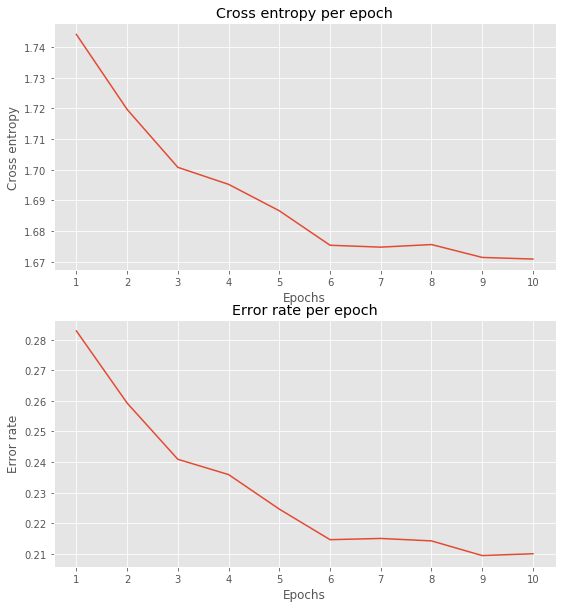

In [21]:
plt.figure(figsize=(9, 10))
plt.subplot(211)
plt.title('Cross entropy per epoch')
plt.xlabel('Epochs')
plt.xticks(range(1, epochs + 1))
plt.ylabel('Cross entropy')
plt.grid(True)
plt.plot(range(1, epochs + 1), losses)

plt.subplot(212)
plt.title('Error rate per epoch')
plt.xlabel('Epochs')
plt.xticks(range(1, epochs + 1))
plt.ylabel('Error rate')
plt.grid(True)
plt.plot(range(1, epochs + 1), error_rates)

plt.show()

Как мы видим, error rate с выбранной архитектурой и параметрами обучения держится на уровне ~1%, что весьма неплохо.

## 2. Обучение и тестирование

Загрузим Fashion MNIST.

In [22]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                          transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
                          batch_size=batch_size,
                          shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False,
                          transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                          ])),
                          batch_size=test_batch_size,
                          shuffle=True, **kwargs)

Обучим и протестируем нашу сеть на новом датасете.

In [38]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

losses = []
error_rates = []

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    (loss, accuracy) = test(model, device, test_loader)
    losses.append(loss)
    error_rates.append(1 - accuracy)
    scheduler.step()

Train Epoch: 1 [0/60000 (0.0%)]	Loss: 2.301853
Train Epoch: 1 [2500/60000 (4.2%)]	Loss: 1.846798
Train Epoch: 1 [5000/60000 (8.3%)]	Loss: 1.858353
Train Epoch: 1 [7500/60000 (12.5%)]	Loss: 1.761293
Train Epoch: 1 [10000/60000 (16.7%)]	Loss: 1.781803
Train Epoch: 1 [12500/60000 (20.8%)]	Loss: 1.827813
Train Epoch: 1 [15000/60000 (25.0%)]	Loss: 1.763019
Train Epoch: 1 [17500/60000 (29.2%)]	Loss: 1.802590
Train Epoch: 1 [20000/60000 (33.3%)]	Loss: 1.748243
Train Epoch: 1 [22500/60000 (37.5%)]	Loss: 1.734872
Train Epoch: 1 [25000/60000 (41.7%)]	Loss: 1.811654
Train Epoch: 1 [27500/60000 (45.8%)]	Loss: 1.708120
Train Epoch: 1 [30000/60000 (50.0%)]	Loss: 1.700411
Train Epoch: 1 [32500/60000 (54.2%)]	Loss: 1.783291
Train Epoch: 1 [35000/60000 (58.3%)]	Loss: 1.719004
Train Epoch: 1 [37500/60000 (62.5%)]	Loss: 1.712340
Train Epoch: 1 [40000/60000 (66.7%)]	Loss: 1.701035
Train Epoch: 1 [42500/60000 (70.8%)]	Loss: 1.779341
Train Epoch: 1 [45000/60000 (75.0%)]	Loss: 1.800056
Train Epoch: 1 [47500/

Train Epoch: 7 [20000/60000 (33.3%)]	Loss: 1.635009
Train Epoch: 7 [22500/60000 (37.5%)]	Loss: 1.710341
Train Epoch: 7 [25000/60000 (41.7%)]	Loss: 1.566952
Train Epoch: 7 [27500/60000 (45.8%)]	Loss: 1.568525
Train Epoch: 7 [30000/60000 (50.0%)]	Loss: 1.625577
Train Epoch: 7 [32500/60000 (54.2%)]	Loss: 1.684137
Train Epoch: 7 [35000/60000 (58.3%)]	Loss: 1.662236
Train Epoch: 7 [37500/60000 (62.5%)]	Loss: 1.702253
Train Epoch: 7 [40000/60000 (66.7%)]	Loss: 1.612807
Train Epoch: 7 [42500/60000 (70.8%)]	Loss: 1.598501
Train Epoch: 7 [45000/60000 (75.0%)]	Loss: 1.604956
Train Epoch: 7 [47500/60000 (79.2%)]	Loss: 1.746836
Train Epoch: 7 [50000/60000 (83.3%)]	Loss: 1.686743
Train Epoch: 7 [52500/60000 (87.5%)]	Loss: 1.677817
Train Epoch: 7 [55000/60000 (91.7%)]	Loss: 1.682259
Train Epoch: 7 [57500/60000 (95.8%)]	Loss: 1.633925

Test set: Average loss: 1.6537, Accuracy: 7989/10000 (79.9%)

Train Epoch: 8 [0/60000 (0.0%)]	Loss: 1.578810
Train Epoch: 8 [2500/60000 (4.2%)]	Loss: 1.685809
Train Ep

Снова построим графики изменения перекрёстной энтропии и error rate с каждой последующей эпохой.

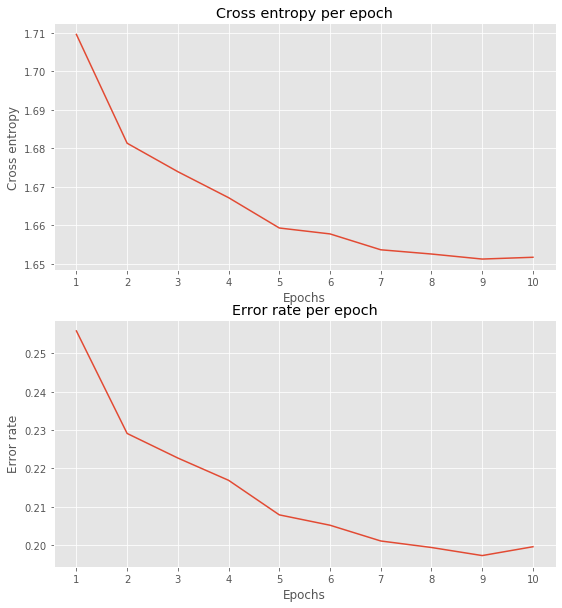

In [39]:
plt.figure(figsize=(9, 10))
plt.subplot(211)
plt.title('Cross entropy per epoch')
plt.xlabel('Epochs')
plt.xticks(range(1, epochs + 1))
plt.ylabel('Cross entropy')
plt.grid(True)
plt.plot(range(1, epochs + 1), losses)

plt.subplot(212)
plt.title('Error rate per epoch')
plt.xlabel('Epochs')
plt.xticks(range(1, epochs + 1))
plt.ylabel('Error rate')
plt.grid(True)
plt.plot(range(1, epochs + 1), error_rates)

plt.show()

Получаем дискуссионный результат: сеть, показывающая на MNIST ~1% error rate, на Fashion MNIST показывает ~20% error rate.

Теперь получим данные для построения матрицы неточностей.

In [40]:
true_labels = []
predicted_labels = []
images_cm = [[(0, 0)] * 10 for i in range(10)]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        true_labels.extend(target.flatten().tolist())
        predicted_labels.extend(pred.flatten().tolist())
        for (image, probabilities, true, predicted) in zip(data, output, target, pred):
            probability = probabilities[predicted].cpu().numpy()[0]
            if images_cm[true][predicted][1] < probability:
                images_cm[true][predicted] = (image.cpu().numpy(), probability)

Построим саму матрицу.

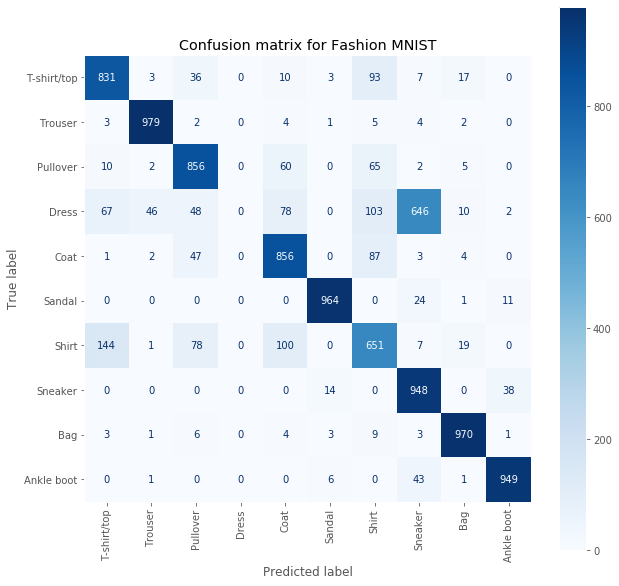

In [41]:
text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=text_labels)
disp.plot(cmap='Blues', xticks_rotation='vertical', values_format='d')
disp.figure_.set_size_inches(10, 10)
plt.title('Confusion matrix for Fashion MNIST')
plt.grid(False)
plt.show()

Построим вторую матрицу, с картинками, где в ячейке *[i, j]* находится картинка класса *i*, которую сеть посчитала наиболее похожей на класс *j*.

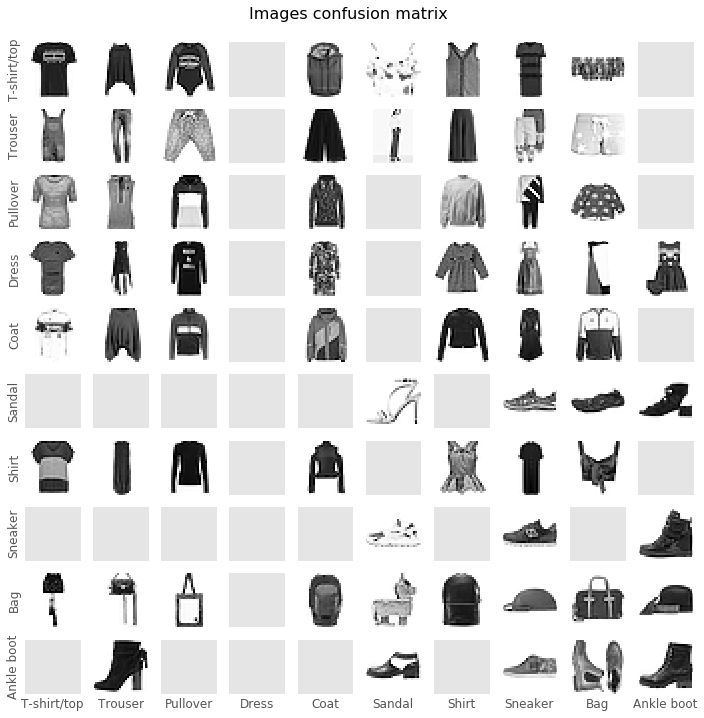

In [42]:
plt.figure(figsize=(12, 12))
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, (i * 10) + j + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        if j == 0: plt.ylabel(text_labels[i])
        if i == 9: plt.xlabel(text_labels[j])

        try:
            plt.imshow(images_cm[i][j][0].flatten().reshape([28, 28]), cmap='Greys')
        except AttributeError:
            pass

plt.suptitle('Images confusion matrix', fontsize=16, y=0.92)
plt.show()